In [116]:
import os
import json
import pandas as pd
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm



In [117]:
files = list(os.walk("../scrapy_projects/etoro/etoro/"))[0][2]


def load_investor_summary():
    etoro_sum_paths = [f for f in files if f.startswith("investor_dashboard")]
    with open(f"../scrapy_projects/etoro/etoro/{ sorted(etoro_sum_paths)[-1]}","r") as f:
        etoro_investor_sum = json.load(f)
        
    return etoro_investor_sum


def load_investor_portfolio():
    
    etoro_investor_paths = [f for f in files if f.startswith("investor_portfolio")]
    etoro_investors = []
    for path in etoro_investor_paths:
        with open(f"../scrapy_projects/etoro/etoro/{path}","r") as f:
            _ = json.load(f)
            etoro_investors.extend(_)


    investor_portfolio = []
    for investor in etoro_investors:
        for item in investor["items"]:
            row = {"investor_name":investor["investor_name"],
                        "date":investor["datetime"],
                        "company":item["company_ticker"],
                        "type":item["type"],
                        "invested":item["invested"].replace("<","").replace("%","")}
            investor_portfolio.append(row)
    return investor_portfolio


# Explore investor summary

In [118]:
investor_portfolio = load_investor_portfolio()
investor_summary = load_investor_summary()

investor_summary_df = pd.DataFrame(investor_summary)
df = pd.DataFrame(investor_portfolio)
df = df.astype({'invested': 'float32'})
df["date"] = pd.to_datetime(df["date"],format='%y-%m-%d')

investor_mapping = dict(zip(investor_summary_df["CustomerId"],investor_summary_df["UserName"]))
investor_summary_df = investor_summary_df.set_index("CustomerId")
investor_summary_df = investor_summary_df[['Gain', 'DailyGain', 'ThisWeekGain', 'RiskScore', 'MaxDailyRiskScore',
       'MaxMonthlyRiskScore', 'Copiers', 'CopyTradesPct', 'Trades', 'WinRatio',
       'DailyDD', 'WeeklyDD', 'ActiveWeeks']]

for col in investor_summary_df:
    investor_summary_df[col] = investor_summary_df[col].apply(lambda x: str(x).replace("$","").replace("+","").replace("M","")).astype(np.float32)

    
investor_summary = StandardScaler().fit_transform(investor_summary_df)



100%|██████████| 29/29 [00:29<00:00,  1.14s/it]


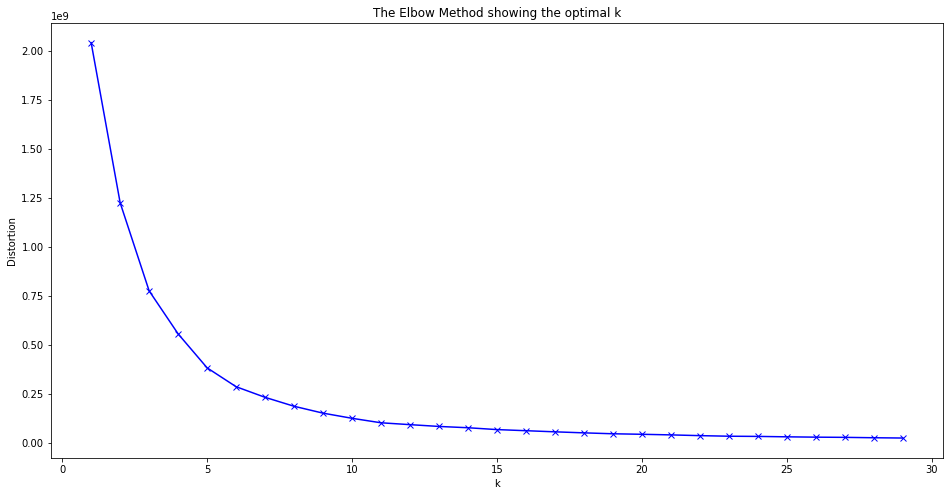

In [119]:
distortions = []
K = range(1,30)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(investor_summary_df)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [120]:
kmeans = KMeans(22)
kmeans.fit(investor_summary)
investor_summary_df["k_means_cluster"] = kmeans.predict(investor_summary)

summ = investor_summary_df.groupby("k_means_cluster").mean()
summ["count"] = investor_summary_df.groupby("k_means_cluster")["k_means_cluster"].count()


In [132]:
summ

,Gain,DailyGain,ThisWeekGain,RiskScore,MaxDailyRiskScore,MaxMonthlyRiskScore,Copiers,CopyTradesPct,Trades,WinRatio,DailyDD,WeeklyDD,ActiveWeeks,count
k_means_cluster,,,,,,,,,,,,,,
0,22.354023,-0.984134,-0.781899,3.201117,4.815642,3.670391,97.089386,5.651467,182.564240,66.759430,-2.983687,-4.485196,51.698322,179
1,63.271381,-1.918618,-1.298487,4.651316,8.263158,5.782895,6.368421,4.030214,271.598694,70.134956,-7.505461,-10.404079,42.894737,152
2,42.979107,-1.810313,0.144330,5.816964,7.026786,5.763393,5.441964,2.709697,215.196426,67.679993,-4.289911,-5.961071,18.727678,224
3,382.764160,90.718330,184.998337,7.250000,8.166667,5.500000,8.666667,4.201520,91.250000,74.254555,-4.963333,-6.223333,26.000000,12
4,45.424122,-2.019389,-1.741527,4.206107,5.870229,4.854962,0.519084,78.874634,28.450382,31.128372,-6.887252,-10.464198,53.961834,131
5,5170.549805,-0.250000,-1.120000,3.000000,5.000000,3.000000,2.000000,33.333332,18.000000,44.444443,-9.390000,-9.850000,19.000000,1
6,44.873344,-1.647914,-1.168971,4.245714,6.505714,5.340000,37.617142,3.419003,181.139999,74.316231,-4.259114,-6.182343,42.779999,350
7,57.760002,-0.755000,-0.440000,3.500000,6.000000,5.000000,16977.500000,0.000000,400.500000,76.471909,-4.310000,-5.605000,57.000000,2
8,83.889999,-1.416667,-0.713333,4.333333,6.000000,4.333333,331.666656,0.382878,10499.000000,70.625282,-4.993333,-8.330000,57.000000,3


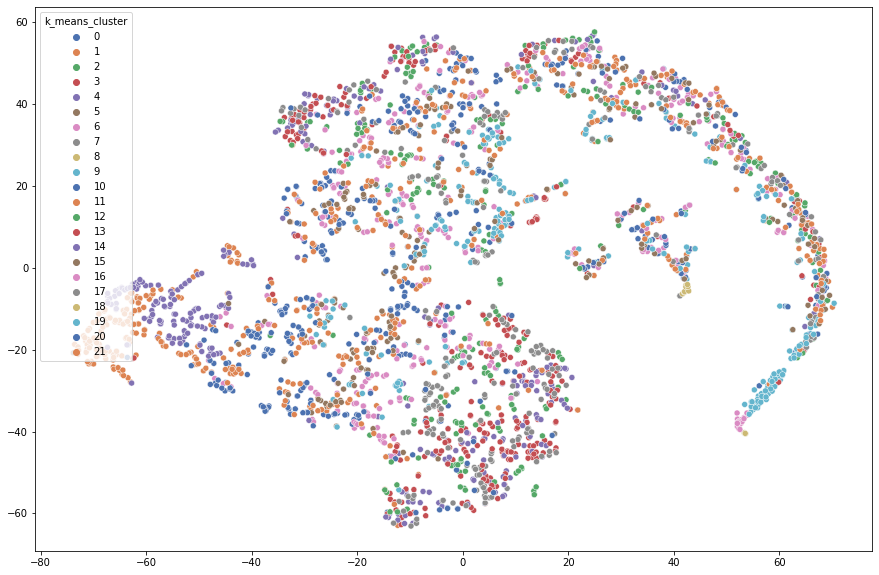

In [133]:
plt.figure(figsize=(15,10))
tsne = TSNE(n_components=2)
tsne_vals = tsne.fit_transform(investor_summary_df)

sns.scatterplot(x=tsne_vals[:,0],y=tsne_vals[:,1],hue=investor_summary_df["k_means_cluster"],palette="deep")

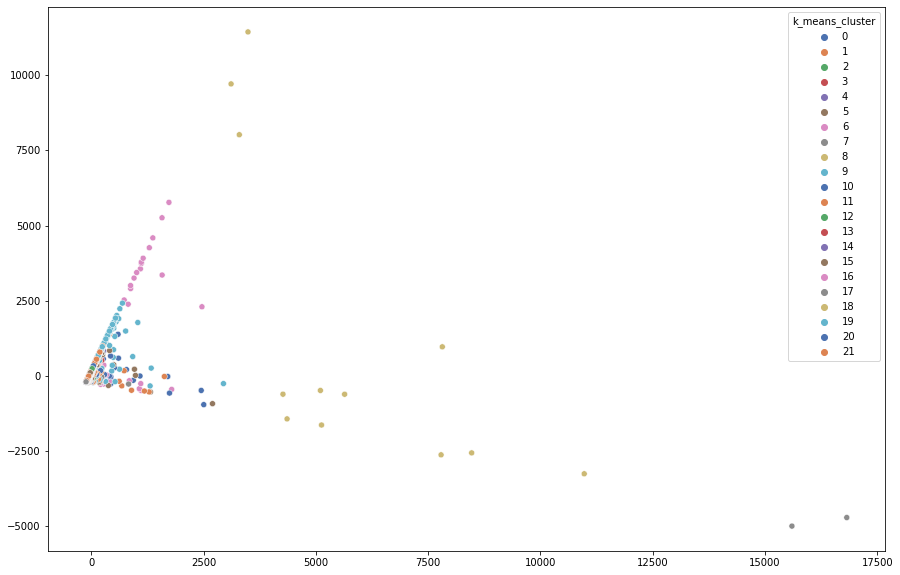

In [134]:
plt.figure(figsize=(15,10))
pca = PCA(n_components=2)
pca_vals = pca.fit_transform(investor_summary_df)

sns.scatterplot(x=pca_vals[:,0],y=pca_vals[:,1],hue=investor_summary_df["k_means_cluster"],palette="deep")

In [135]:
best_investors =investor_summary_df[investor_summary_df["k_means_cluster"].isin([0,9,16,18])]
best_investors.sort_values("Gain",ascending=False)

,Gain,DailyGain,ThisWeekGain,RiskScore,MaxDailyRiskScore,MaxMonthlyRiskScore,Copiers,CopyTradesPct,Trades,WinRatio,DailyDD,WeeklyDD,ActiveWeeks,k_means_cluster
CustomerId,,,,,,,,,,,,,,
13529159,180.550003,-2.10,-1.35,5.0,7.0,6.0,518.0,0.044643,2240.0,82.232140,-6.24,-10.48,46.0,9
13622929,154.309998,-4.68,-3.55,6.0,7.0,6.0,5.0,0.000000,2201.0,76.010902,-9.00,-12.17,45.0,9
11552670,148.839996,-1.80,-1.69,5.0,7.0,6.0,1.0,0.211752,1889.0,54.843834,-6.10,-13.80,46.0,9
6084415,140.470001,0.72,4.72,4.0,7.0,5.0,2941.0,0.000000,864.0,60.416668,-4.37,-9.88,57.0,9
13278929,132.210007,7.96,10.94,6.0,8.0,6.0,1.0,0.520833,1536.0,84.309898,-8.93,-12.63,48.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4941191,5.970000,-0.74,-0.47,3.0,5.0,3.0,1.0,4.142012,169.0,21.893492,-1.01,-1.55,55.0,0
14039288,5.380000,-0.73,-0.65,3.0,3.0,3.0,6.0,0.000000,34.0,50.000000,-2.24,-3.27,40.0,0
2902284,5.280000,0.39,1.16,3.0,4.0,3.0,4.0,19.512196,41.0,60.975609,-2.35,-3.33,57.0,0


In [136]:
for investor_id in best_investors.index.values:
    print(investor_id, investor_mapping[investor_id])

10633478 Social-Investor
9629091 oceantan007
6084415 CanZhao
11794700 balticseal
10629526 Slow_and_Steady
5526194 ALnayef
11011648 Martidg97
12363123 pino428
10245777 DavidePerina
10478936 SherryMalik
2594664 daniel4653
9236441 tradefx525
7126268 Renoi974
13675706 Doopiecash
3252879 Trex8u247
13470305 Wong1313
12495588 AndyCleaver
13472564 RobertMERC
13501691 Coolcontribution
2070376 chocowin
3815892 NestorArmstrong
5892436 tomchapman1979
6210906 openwings
10349438 Arasiqsi
9600074 ylihao
9730546 WeiHong95
12809189 MisterZtrading
13044116 MGFund
5902244 ValueFund
250831 vidinho
4107041 dpriscal
5161065 niclam2203
12807932 SafeHavenZ
5557587 Fedez255
14545045 Myx-Algo-System
4190620 GoldenEight
11206309 NURIAGL1
6778943 aar0ntw
12845632 gytisviskacka
12579226 SafePortfolio
14605988 MercifulKnight
4064415 Thinkandhu
16157384 JustinC2
10997515 LongbowArcher
9942134 IHUAHUANG
9509269 tintinmelo75
5849524 PlayBass
12733352 EdenLiang
6591862 Ivanfxx
10668510 Ilakha
13043420 QualityHedge
5509

# Explore individual stocks

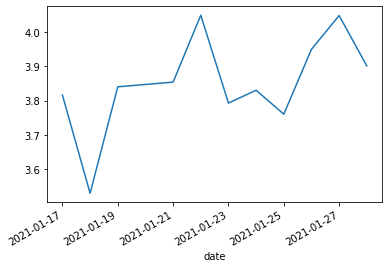

In [6]:
df[df.company=='MSFT'].groupby('date')['invested'].mean().plot()

In [7]:
len(df.company.unique())

2224

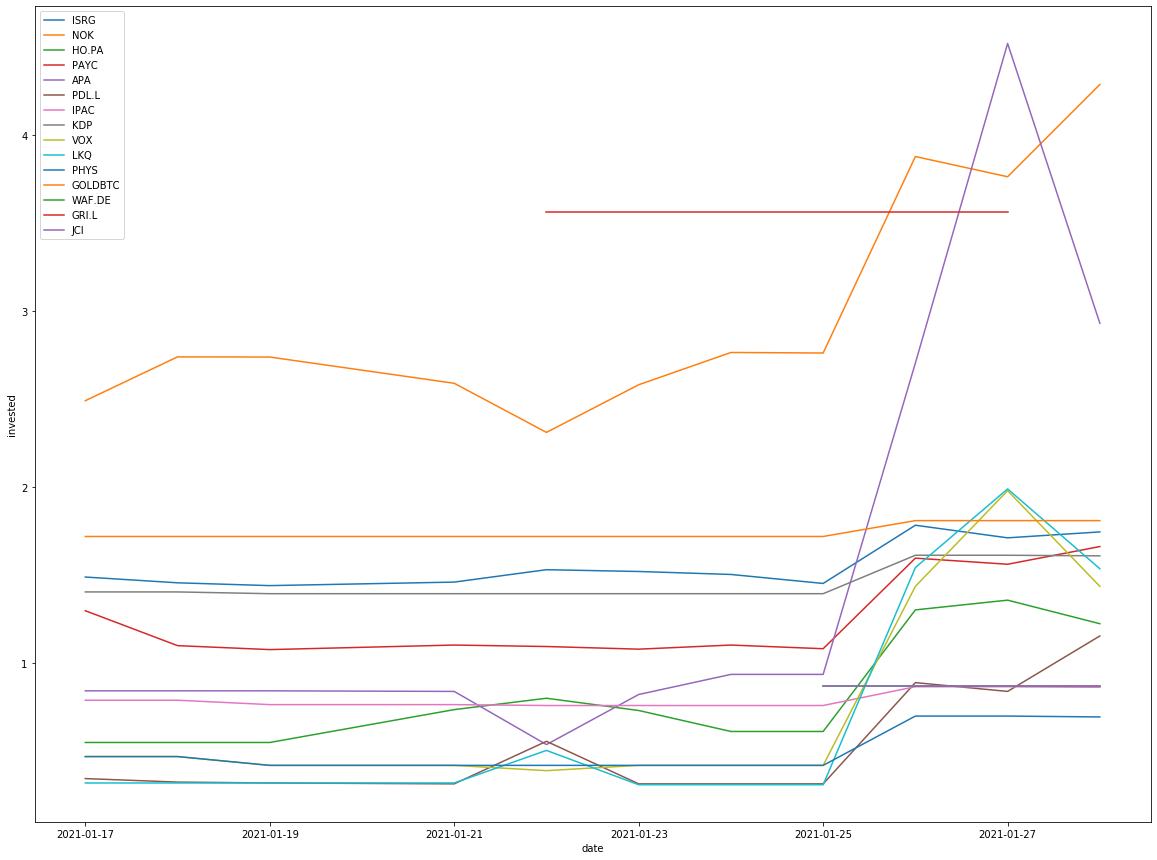

In [9]:
plt.figure(figsize=(20,15))
for stock_name in df.company.value_counts().index:
    plot_data = df[df.company==stock_name].groupby('date')['invested'].mean()
    if plot_data[-3:].mean() > plot_data[:-3].mean() + 2*plot_data.std():
        sns.lineplot(x=plot_data.index,y=plot_data,label=stock_name)       
plt.legend()